Try use topic modeling to calculate the semantic similarities between the text.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction import text 

import nltk
nltk.download('punkt')


from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF
# improve the model with lemmatization 
# use a different vectorizer. 

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

count_vectorizer = text.CountVectorizer(tokenizer=LemmaTokenizer(),
                                strip_accents = 'unicode', # works 
                                stop_words = 'english', # works
                                lowercase = True, # works
                                max_df = 0.5, # works
                                min_df = 10) # works


tfidf_vectorizer = text.TfidfVectorizer(tokenizer=LemmaTokenizer(),
                                strip_accents = 'unicode', # works 
                                stop_words = 'english', # works
                                lowercase = True, # works
                                max_df = 0.5, # works
                                min_df = 10) # works

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
wiki_phys = pd.read_csv("../../nlp_clean/wiki_phys_cleaned.csv")
wiki_phys.drop_duplicates("Name",inplace=True)

In [3]:
# did not stratify since The least populated class in y has only 1 member, which is too few.
wiki_phys_X, wiki_phys_X_test, wiki_phys_y, wiki_phys_y_test = train_test_split(wiki_phys.drop("Subcategory",axis=1), wiki_phys["Subcategory"],
                                                                                test_size=0.3, random_state=7)

In [4]:
wiki_phys = pd.concat([wiki_phys_X,wiki_phys_y], axis=1)

In [5]:
wiki_phys.head()

,Name,Link,Text,Length,Reference,Subcategory
1175,Noise-equivalent flux density,https://en.wikipedia.org/wiki/Noise-equivalent...,optic flux density nefd irradiance nei system ...,145,"['Optics', 'Flux', 'Signal noise', 'Noise-equi...",Physical quantities
1226,Sound power,https://en.wikipedia.org/wiki/Sound_power,sound power acoustic power rate sound energy e...,739,"['Sound energy', 'International System of Unit...",Physical quantities
303,Arthur Jaffe,https://en.wikipedia.org/wiki/Arthur_Jaffe,arthur michael jaffe born december american ma...,409,"['Help:IPA/English', 'United States', 'Mathema...",Physicists
1189,Phase (waves),https://en.wikipedia.org/wiki/Phase_(waves),phase position point time instant waveform cyc...,1119,"['Waveform', 'Turn (geometry)', 'Radian', 'Dis...",Physical quantities
1105,Frequency,https://en.wikipedia.org/wiki/Frequency,frequency number occurrence repeating event pe...,1721,"['Unit of time', 'Spatial frequency', 'Angular...",Physical quantities


In [6]:
wiki_phys_test = pd.concat([wiki_phys_X_test,wiki_phys_y_test], axis=1)

In [7]:
len(wiki_phys['Subcategory'].value_counts())

26

## Using LDA mode with CountVectorizer

In [8]:
data_count_vectorized=count_vectorizer.fit_transform(wiki_phys['Text'].values.astype('U'))

lda_model_count=LDA(n_components=26
              ,max_iter=100,learning_method='batch').fit(data_count_vectorized)

## Using LDA model with TfidfVectorizer

In [9]:
data_tfidf_vectorized=tfidf_vectorizer.fit_transform(wiki_phys['Text'].values.astype('U'))
lda_model_tfidf=LDA(n_components=26
              ,max_iter=100,learning_method='batch').fit(data_tfidf_vectorized)

In [10]:
def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])

# Using NMF models with TfidfVectorizer 

In [11]:
nmf_model_tfidf=NMF(n_components=26).fit(data_tfidf_vectorized)

# Using NMF with CountVectorizer 

In [12]:
nmf_model_count=NMF(n_components=26).fit(data_count_vectorized)

In [27]:
print_topics(lda_model_count, count_vectorizer)

#print_topics(lda_model_tfidf, count_vectorizer)

Topic 0:
[('university', 436.78472875758013), ('research', 354.72159304662955), ('prize', 338.9651944843306), ('science', 333.94528455018326), ('awarded', 273.25767883717447), ('society', 257.33392822628832), ('award', 223.22731656224687), ('american', 211.40990780571119), ('physicist', 203.47422634584797), ('physical', 200.86641557926083)]
Topic 1:
[('theory', 418.24832351977886), ('experiment', 316.37989710161145), ('work', 313.6034497984453), ('century', 261.59857687984703), ('later', 244.84807445679314), ('published', 209.34590484495914), ('book', 194.72787473714197), ('time', 192.00473704490676), ('element', 182.18696779851848), ('idea', 181.96567471000415)]
Topic 2:
[('equation', 1931.8373765769581), ('solution', 435.87761128722684), ('function', 392.74745458656298), ('term', 346.42155443806229), ('problem', 292.6274724791939), ('coefficient', 268.18950033418173), ('form', 262.46757091087596), ('density', 229.19493092702984), ('used', 220.33319798951499), ('number', 216.207062177

Some of the grouped key words indeed made sense. But how to measure the model's performance? 

# define the top10 precision metric

The top10 precision metric is defined as the precision for top10 of the recommended articles to be in the same subcategory as the one you are reading. 

It is not a perfect metric since you might want diversity in the category you read and relevant articles are not always in the same category. But it is a good metric to use for the first iteration of the recommendation engine. 

In [14]:
from sklearn.metrics.pairwise import cosine_similarity as cos_sim

def top_n_index_sorted(array, top_n):
    # get the index of top 10 values in the array
    index = np.argpartition(array,-top_n)[-top_n:]
    
    # return the index of the sorted top_n values 
    return index[np.argsort(array[index])]

def top10_recommend_index(index,model,data,top_n):
    # transform the data using the model
    lda_vectors=model.transform(data)
    # calculate the cos similarity from the lda vectors 
    similarity=cos_sim(lda_vectors)
    
    top_n_index=top_n_index_sorted(similarity[index,],top_n+1)
    
    # get the decreasing similarity index
    return top_n_index[::-1]    
# example 
# top10_recommend_index(2,lda_model_2,data_count_vectorized,10)


In [15]:
top10_recommend_index(1,lda_model_count,data_count_vectorized,10)

array([  1, 751, 610, 876,   4, 394, 502,  52,  39, 157, 491])

In [16]:
def top10_precision(top_n_index,data):
    
    # get the subcategory data
    recommended_subcategory = wiki_phys["Subcategory"].iloc[top_n_index]
    recommended_subcategory = recommended_subcategory.values

    
    return sum(recommended_subcategory[0]==recommended_subcategory[1:])/len(recommended_subcategory[1:])


In [17]:
top10_precision(top10_recommend_index(4,lda_model_count,data_count_vectorized,10), wiki_phys)

0.69999999999999996

In [18]:
# for the progress bar
from tqdm import tqdm

def precision_list(data,model,vectorized_text):
    
    length = data.shape[0]
    # initialize the list 
    precision = [0]*length
    

    for i in tqdm(range(length)):
        precision[i] = top10_precision(top10_recommend_index(i,model,vectorized_text,10), data)
    
    return precision    

## Vectorized the test data 

In [19]:
tfidf_test_vectorized = tfidf_vectorizer.transform(wiki_phys_test['Text'].values.astype('U'))

count_test_vectorized = count_vectorizer.transform(wiki_phys_test['Text'].values.astype('U'))

## Calculate the performance on the test data

In [20]:
lda_tfidf_precision = precision_list(wiki_phys_test,lda_model_tfidf,tfidf_test_vectorized)

100%|██████████| 444/444 [00:15<00:00, 16.48it/s]


In [21]:
lda_count_precision = precision_list(wiki_phys_test,lda_model_count,data_count_vectorized)

100%|██████████| 444/444 [04:07<00:00,  1.64it/s]


In [22]:
nmf_count_precision = precision_list(wiki_phys_test,nmf_model_count,data_count_vectorized)

100%|██████████| 444/444 [00:24<00:00, 17.43it/s]


In [23]:
nmf_tfidf_precision = precision_list(wiki_phys_test,nmf_model_tfidf,tfidf_test_vectorized)

100%|██████████| 444/444 [00:11<00:00, 39.08it/s]


In [24]:
precision_df = pd.DataFrame()

precision_df["lda_tfidf"] = pd.Series(lda_tfidf_precision)
precision_df['lda_count'] = pd.Series(lda_count_precision)
precision_df['nmf_tfidf'] = pd.Series(nmf_tfidf_precision)
precision_df['nmf_count'] = pd.Series(nmf_count_precision)

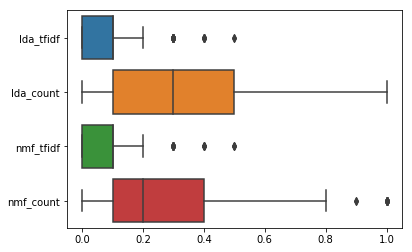

In [25]:
sns.boxplot(data=precision_df, orient="h")

Text(0.5,0,'Precision distribution for different algorithm with different vectorizer')

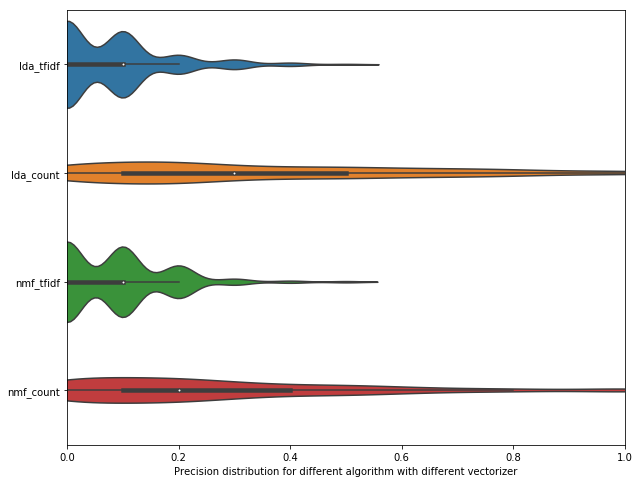

In [26]:
plt.figure(figsize=(10,8))

sns.violinplot(data=precision_df, orient="h")
plt.xlim(0,1)
plt.xlabel("Precision distribution for different algorithm with different vectorizer")